In [18]:
import os, getpass
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
import json
import gradio as gr
from langchain_core.messages import ToolMessage

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [3]:
class MultiplyInputSchema(BaseModel):
    """Multiply two numbers"""
    a: int = Field(description="First operand")
    b: int = Field(description="Second operand")

In [4]:
@tool("multiply_tool",args_schema=MultiplyInputSchema)
def multiply(a: int, b: int) -> int:
    print("run multiply tools")
    return a * b

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
llm = init_chat_model("openai:gpt-4o-mini")

In [8]:
tools = [multiply]

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [11]:
graph_builder.add_node("chatbot", chatbot)

In [12]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [13]:
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [14]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [15]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

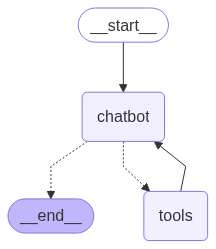

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
def stream_graph_updates(user_input: str):
    msg = {"role": "user", "content": user_input}
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            msg["content"] = value["messages"][-1].content
    return msg

# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break
#
#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

In [21]:
def chat(question, history):
    return stream_graph_updates(question)


view = gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
